The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.16.4


# Minibatch Stochastic Gradient Descent
:label:`sec_minibatch_sgd`

So far we encountered two extremes in the approach to gradient based learning: :numref:`sec_gd` uses the full dataset to compute gradients and to update parameters, one pass at a time. Conversely :numref:`sec_sgd` processes one observation at a time to make progress. Each of them has its own drawbacks. Gradient Descent is not particularly *data efficient* whenever data is very similar. Stochastic Gradient Descent is not particularly *computationally efficient* since CPUs and GPUs cannot exploit the full power of vectorization. This suggests that there might be a happy medium, and in fact, that's what we have been using so far in the examples we discussed.

## Vectorization and Caches

At the heart of the decision to use minibatches is computational efficiency. This is most easily understood when considering parallelization to multiple GPUs and multiple servers. In this case we need to send at least one image to each GPU. With 8 GPUs per server and 16 servers we already arrive at a minibatch size of 128.

Things are a bit more subtle when it comes to single GPUs or even CPUs. These devices have multiple types of memory, often multiple type of compute units and different bandwidth constraints between them. For instance, a CPU has a small number of registers and then L1, L2 and in some cases even L3 cache (which is shared between the different processor cores). These caches are of increasing size and latency (and at the same time they are of decreasing bandwidth). Suffice it to say, the processor is capable of performing many more operations than what the main memory interface is able to provide.

* A 2GHz CPU with 16 cores and AVX-512 vectorization can process up to $2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$ bytes per second. The capability of GPUs easily exceeds this number by a factor of 100. On the other hand, a midrange server processor might not have much more than 100 GB/s bandwidth, i.e., less than one tenth of what would be required to keep the processor fed. To make matters worse, not all memory access is created equal: first, memory interfaces are typically 64 bit wide or wider (e.g., on GPUs up to 384 bit), hence reading a single byte incurs the cost of a much wider access.
* There is significant overhead for the first access whereas sequential access is relatively cheap (this is often called a burst read). There are many more things to keep in mind, such as caching when we have multiple sockets, chiplets and other structures. A detailed discussion of this is beyond the scope of this section. See e.g., this [Wikipedia article](https://en.wikipedia.org/wiki/Cache_hierarchy) for a more in-depth discussion.

The way to alleviate these constraints is to use a hierarchy of CPU caches which are actually fast enough to supply the processor with data. This is *the* driving force behind batching in deep learning. To keep matters simple, consider matrix-matrix multiplication, say $\mathbf{A} = \mathbf{B}\mathbf{C}$. We have a number of options for calculating $\mathbf{A}$. For instance we could try the following:

1. We could compute $\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$, i.e., we could compute it elementwise by means of dot products.
1. We could compute $\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$, i.e., we could compute it one column at a time. Likewise we could compute $\mathbf{A}$ one row $\mathbf{A}_{i,:}$ at a time.
1. We could simply compute $\mathbf{A} = \mathbf{B} \mathbf{C}$.
1. We could break $\mathbf{B}$ and $\mathbf{C}$ into smaller block matrices and compute $\mathbf{A}$ one block at a time.

If we follow the first option, we will need to copy one row and one column vector into the CPU each time we want to compute an element $\mathbf{A}_{ij}$. Even worse, due to the fact that matrix elements are aligned sequentially we are thus required to access many disjoint locations for one of the two vectors as we read them from memory. The second option is much more favorable. In it, we are able to keep the column vector $\mathbf{C}_{:,j}$ in the CPU cache while we keep on traversing through $B$. This halves the memory bandwidth requirement with correspondingly faster access. Of course, option 3 is most desirable. Unfortunately, most matrices might not entirely fit into cache (this is what we are discussing after all). However, option 4 offers a practically useful alternative: we can move blocks of the matrix into cache and multiply them locally. Optimized libraries take care of this for us. Let us have a look at how efficient these operations are in practice.

Beyond computational efficiency, the overhead introduced by Python and by the deep learning framework itself is considerable. Recall that each time we execute a command the Python interpreter sends a command to the MXNet engine which needs to insert it into the computational graph and deal with it during scheduling. Such overhead can be quite detrimental. In short, it is highly advisable to use vectorization (and matrices) whenever possible.


In [1]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

Element-wise assignment simply iterates over all rows and columns of $\mathbf{B}$ and $\mathbf{C}$ respectively to assign the value to $\mathbf{A}$.


In [2]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.2187190055847168

A faster strategy is to perform column-wise assignment.


In [3]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.14270710945129395

Last, the most effective manner is to perform the entire operation in one block. Let us see what the respective speed of the operations is.


In [4]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

# Multiply and add count as separate operations (fused in practice)
gigaflops = [2 / i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 1.641, column 14.015, full 390.640


## Minibatches

:label:`sec_minibatches`

In the past we took it for granted that we would read *minibatches* of data rather than single observations to update parameters. We now give a brief justification for it. Processing single observations requires us to perform many single matrix-vector (or even vector-vector) multiplications, which is quite expensive and which incurs a significant overhead on behalf of the underlying deep learning framework. This applies both to evaluating a network when applied to data (often referred to as inference) and when computing gradients to update parameters. That is, this applies whenever we perform $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ where

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$$

We can increase the *computational* efficiency of this operation by applying it to a minibatch of observations at a time. That is, we replace the gradient $\mathbf{g}_t$ over a single observation by one over a small batch

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})$$

Let us see what this does to the statistical properties of $\mathbf{g}_t$: since both $\mathbf{x}_t$ and also all elements of the minibatch $\mathcal{B}_t$ are drawn uniformly at random from the training set, the expectation of the gradient remains unchanged. The variance, on the other hand, is reduced significantly. Since the minibatch gradient is composed of $b := |\mathcal{B}_t|$ independent gradients which are being averaged, its standard deviation is reduced by a factor of $b^{-\frac{1}{2}}$. This, by itself, is a good thing, since it means that the updates are more reliably aligned with the full gradient.

Naively this would indicate that choosing a large minibatch $\mathcal{B}_t$ would be universally desirable. Alas, after some point, the additional reduction in standard deviation is minimal when compared to the linear increase in computational cost. In practice we pick a minibatch that is large enough to offer good computational efficiency while still fitting into the memory of a GPU. To illustrate the savings let us have a look at some code. In it we perform the same matrix-matrix multiplication, but this time broken up into "minibatches" of 64 columns at a time.


In [5]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j + 64] = torch.mm(B, C[:, j:j + 64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 161.282


As we can see, the computation on the minibatch is essentially as efficient as on the full matrix. A word of caution is in order. In :numref:`sec_batch_norm` we used a type of regularization that was heavily dependent on the amount of variance in a minibatch. As we increase the latter, the variance decreases and with it the benefit of the noise-injection due to batch normalization. See e.g., :cite:`Ioffe.2017` for details on how to rescale and compute the appropriate terms.

## Reading the Dataset

Let us have a look at how minibatches are efficiently generated from data. In the following we use a dataset developed by NASA to test the wing [noise from different aircraft](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) to compare these optimization algorithms. For convenience we only use the first $1,500$ examples. The data is whitened for preprocessing, i.e., we remove the mean and rescale the variance to $1$ per coordinate.


In [6]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'), dtype=np.float32,
                         delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]), batch_size,
                               is_train=True)
    return data_iter, data.shape[1] - 1

## Implementation from Scratch

Recall the minibatch stochastic gradient descent implementation from :numref:`sec_linear_scratch`. In the following we provide a slightly more general implementation. For convenience it has the same call signature as the other optimization algorithms introduced later in this chapter. Specifically, we add the status
input `states` and place the hyperparameter in dictionary `hyperparams`. In
addition, we will average the loss of each minibatch example in the training
function, so the gradient in the optimization algorithm does not need to be
divided by the batch size.


In [7]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

Next, we implement a generic training function to facilitate the use of the other optimization algorithms introduced later in this chapter. It initializes a linear regression model and can be used to train the model with minibatch stochastic gradient descent and other algorithms introduced subsequently.


In [8]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim,
               num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n / X.shape[0] / len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

Let us see how optimization proceeds for batch gradient descent. This can be achieved by setting the minibatch size to 1500 (i.e., to the total number of examples). As a result the model parameters are updated only once per epoch. There is little progress. In fact, after 6 steps progress stalls.


loss: 0.244, 0.042 sec/epoch


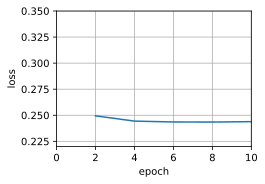

In [9]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(sgd, None, {'lr': lr}, data_iter, feature_dim,
                      num_epochs)

gd_res = train_sgd(1, 1500, 10)

When the batch size equals 1, we use stochastic gradient descent for optimization. For simplicity of implementation we picked a constant (albeit small) learning rate. In stochastic gradient descent, the model parameters are updated whenever an example is processed. In our case this amounts to 1500 updates per epoch. As we can see, the decline in the value of the objective function slows down after one epoch. Although both the procedures processed 1500 examples within one epoch, stochastic gradient descent consumes more time than gradient descent in our experiment. This is because stochastic gradient descent updated the parameters more frequently and since it is less efficient to process single observations one at a time.


loss: 0.244, 0.078 sec/epoch


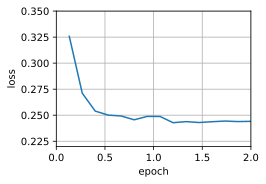

In [10]:
sgd_res = train_sgd(0.005, 1)

Finally, when the batch size equals 100, we use minibatch stochastic gradient descent for optimization. The time required per epoch is shorter than the time needed for stochastic gradient descent and the time for batch gradient descent.


loss: 0.245, 0.003 sec/epoch


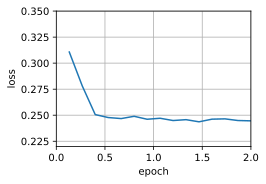

In [11]:
mini1_res = train_sgd(.4, 100)

Reducing the batch size to 10, the time for each epoch increases because the workload for each batch is less efficient to execute.


loss: 0.245, 0.009 sec/epoch


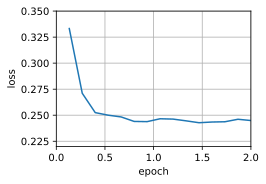

In [12]:
mini2_res = train_sgd(.05, 10)

Now we can compare the time vs. loss for the previous four experiments. As can be seen, although stochastic gradient descent converges faster than GD in terms of number of examples processed, it uses more time to reach the same loss than GD because computing the gradient example by example is not as efficient. Minibatch stochastic gradient descent is able to trade-off convergence speed and computation efficiency. A minibatch size of 10 is more efficient than stochastic gradient descent; a minibatch size of 100 even outperforms GD in terms of runtime.


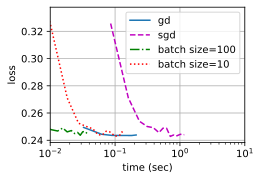

In [13]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

## Concise Implementation

In Gluon, we can use the `Trainer` class to call optimization algorithms. This is used to implement a generic training function. We will use this throughout the current chapter.


In [14]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))

    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)

    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)

    loss = nn.MSELoss()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    # value to get L2Loss in PyTorch
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y) / 2
            l.backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n / X.shape[0] / len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

Using Gluon to repeat the last experiment shows identical behavior.


loss: 0.243, 0.011 sec/epoch


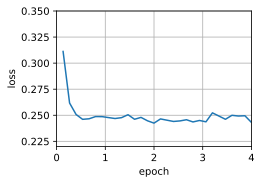

In [15]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter)

## Summary

* Vectorization makes code more efficient due to reduced overhead arising from the deep learning framework and due to better memory locality and caching on CPUs and GPUs.
* There is a trade-off between statistical efficiency arising from stochastic gradient descent and computational efficiency arising from processing large batches of data at a time.
* Minibatch stochastic gradient descent offers the best of both worlds: computational and statistical efficiency.
* In minibatch stochastic gradient descent we process batches of data obtained by a random permutation of the training data (i.e., each observation is processed only once per epoch, albeit in random order).
* It is advisable to decay the learning rates during training.
* In general, minibatch stochastic gradient descent is faster than stochastic gradient descent and gradient descent for convergence to a smaller risk, when measured in terms of clock time.

## Exercises

1. Modify the batch size and learning rate and observe the rate of decline for the value of the objective function and the time consumed in each epoch.
1. Read the MXNet documentation and use the `Trainer` class `set_learning_rate` function to reduce the learning rate of the minibatch stochastic gradient descent to 1/10 of its previous value after each epoch.
1. Compare minibatch stochastic gradient descent with a variant that actually *samples with replacement* from the training set. What happens?
1. An evil genie replicates your dataset without telling you (i.e., each observation occurs twice and your dataset grows to twice its original size, but nobody told you). How does the behavior of stochastic gradient descent, minibatch stochastic gradient descent and that of gradient descent change?


[Discussions](https://discuss.d2l.ai/t/1068)
